In [14]:
import pandas as pd
from datetime import datetime 
import sys
from collections import Counter
import operator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from pymorphy2 import MorphAnalyzer
import numpy as np
import json
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [10]:
def time_str():
    return ('%s' % datetime.now().replace(microsecond=0)).replace(' ','_')

## Data Load Section    
    Script for preparing data - sorts queries and for each uniq query finds it frequency (uniq for counting frequency means uniq pair:  date and user), no text preprocessing. Data file is big so it sorts it using tmp files on disk, no RAM used(almost)

    ./make_uniq_sorted.sh 
     usage: -i input_file -o output_file [-t tmp_file_for_sorting]

    Code bolow do the same thing but everything in RAM, highly recommend not use it)

In [ ]:
path = '../data/TimelineProblemData.txt'
batch_size = 10 ** 7
batch_counter = 1

limit = None
l = []

print("Start loading "+path, time_str())
for chunk in pd.read_csv(path, encoding='utf-8', sep='[\t\n]', chunksize=batch_size, names=['userID', 'date', 'query'], engine='python'): 
    sys.stderr.write("\rLoaded %d batches, totally %d lines" % (batch_counter, batch_counter*batch_size))
    if batch_counter==1:
        data_group = chunk[chunk['query'] != '*'].drop_duplicates()[['date', 'query']] \
                    .groupby(['date', 'query']).size().reset_index().rename(columns={0:'count'}) \
                    .set_index(['date', 'query'])
    else:
        data_group = data_group.add(chunk[chunk['query'] != '*'].drop_duplicates()[['date', 'query']] \
                      .groupby(['date', 'query']).size().reset_index().rename(columns={0:'count'}) \
                      .set_index(['date', 'query']), axis='columns', fill_value=0)
    if batch_counter==limit:
        break
    batch_counter = batch_counter + 1
print("Finish loading ", time_str())

    Now data saved in sorted.txt, we can use it

In [ ]:
path = '../data/log.txt'
n  = 10000 # we take 10000 most frequent queries
keywords = []
freq = []
with open(path) as in_file:
    for _ in range(n):
        r = re.match(' *(\w*) (.*)', in_file.readline())
        freq.append(r.group(1))
        keywords.append(r.group(2))

## Clusterization    
    Clusterization: K-means, using Morpho analizer for parsing, russian stopwords from nltk.corpus, as features  - tf-idf, amount of clusters equal n/5

In [ ]:
m = MorphAnalyzer()

class LemmTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda x:(m.parse(word)[0].normal_form for word in analyzer(x))

stop_words = stopwords.words('russian')
tfidf_lemm_vec = LemmTfidfVectorizer(min_df=2, stop_words=stop_words)

print("making tfidf_lemm_vec from x", time_str())
X = tfidf_lemm_vec.fit_transform(keywords)
print('made tfidf from  X', time_str())
n_clusters = int(len(keywords)/5)
print(n_clusters)
k_means = KMeans(n_clusters=n_clusters,
        init='k-means++',
        n_init=10,
        max_iter=300,
        tol=0.0001,
        n_jobs=8)


print('start fitting', time_str())
k_means.fit(X)
print('finished fitting', time_str())

    make word2cluster and cluster2words dictionaries and save them

In [ ]:
word2cluster = {}
for i, w in enumerate(keywords):
    word2cluster[w] = int(k_means.labels_[i])
cluster2words = {}
for w in word2cluster:
    if word2cluster[w] in cluster2words:
        cluster2words[word2cluster[w]].append(w)
    else:
        cluster2words[word2cluster[w]] = [w]
with open('../data/word2cluster.json', 'w') as outfile:
    json.dump(word2cluster, outfile)
with open('../data/cluster2words.json', 'w') as outfile:
    json.dump(cluster2words, outfile)

    and now load them

In [184]:
with open('../data/word2cluster.json') as outfile:
    word2cluster = json.load(outfile)
with open('../data/cluster2words.json') as outfile:
    cluster2words = json.load(outfile)

In [185]:
#find cluster with rubbish and split it in separece clusters
m = sorted(([(len(cluster2words[item]), item) for item in cluster2words]), key=lambda x:x[0], reverse=True)[0][1]
cl_num = int(len(cluster2words))
for word in cluster2words[m]:
    cluster2words[str(cl_num+1)] = word
    word2cluster[word] = str(cl_num+1)
    cl_num += 1
cluster2words[m] = ""


    according to clusters we load part of initial dataset

In [186]:
path = '../data/TimelineProblemData.txt'
print("Start loading "+path, time_str())
batch_size = 10 ** 6
batch_counter = 1
limit = None
l = []
word_cl_list = list(word2cluster)
for chunk in pd.read_csv(path, encoding='utf-8', sep='[\t\n]', chunksize=batch_size, names=['userID', 'date', 'query'], engine='python'): 
    sys.stderr.write("\rLoaded %d batches, totally %d lines at %s" % (batch_counter, batch_counter*batch_size, time_str()))
    if batch_counter==1:
        df = chunk[chunk['query'].isin(word_cl_list)].drop_duplicates()
    else:
        df = pd.concat([df, chunk[chunk['query'].isin(word_cl_list)]]).drop_duplicates()
    if batch_counter==limit:
        break
    batch_counter = batch_counter + 1
print("Finish loading ", time_str())

Start loading ../data/TimelineProblemData.txt 2017-08-09_16:58:35


Loaded 1 batches, totally 1000000 lines at 2017-08-09_16:58:42

KeyboardInterrupt: 

    set cluster num to query, group by date and save it

In [ ]:
df['cluster'] = [word2cluster[q] for q in df['query']]
df = df[['userID', 'date', 'query', 'cluster']]
df_data_group = df.groupby(['date', 'cluster']).size().reset_index().rename(columns={0:'count'}) \
                    .set_index(['date', 'cluster'])
df_data_group = df_data_group.reset_index()
df_data_group.to_csv('df_data_group.csv', columns=['date', 'cluster', 'count'])

In [187]:
df_data_group = pd.read_csv('df_data_group.csv')
df_data_group = df_data_group[['date', 'cluster', 'count']]

    now experiment with periods of interest

In [188]:
cluster = 16
df = df_data_group[df_data_group['cluster']==cluster]
x = list(df['date'])
y = list(df['count'])

    delete holidays and eleminate increases/decreases if there are some in the row

In [182]:
#y = [y[i] for i in range(len(x)) if not (x[i]%7%5==0)|(x[i]%7%6==0)]
#x = [x[i] for i in range(len(x)) if not (x[i]%7%5==0)|(x[i]%7%6==0)]

y_2 = [y[0]]
x_2 = [x[0]]
tmp_frac = True
for i in range(1, len(y)):
    frac = y[i] > y[i-1]
    if frac==tmp_frac:
        continue
    else:
        y_2.append(y[i-1])
        x_2.append(x[i-1])
        tmp_frac = frac

y = y_2
x = x_2

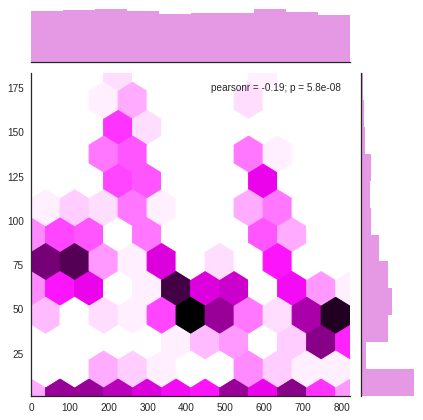

In [189]:
import seaborn as sns
with sns.axes_style("white"):
        sns.jointplot(x=np.array(x), y=np.array(y), kind="hex", color='m');#hex, kde
        plt.show()

## Interest per day prediction

In [173]:
def mean_from_period(data_group, cluster, begin, end):
    return data_group[(data_group.date>=begin)&
           (data_group.date<=end)&
           (data_group['cluster']==cluster)]['count'].mean()
def count_for_period(data_group, cluster, begin, end):
    if cluster==None:
        return data_group[(data_group.date>=begin)&
           (data_group.date<=end)]['count'].sum()
    else:
        return data_group[(data_group.date>=begin)&
           (data_group.date<=end)&
           (data_group['cluster']==cluster)]['count'].sum()

In [174]:
def wave_for_period(df, cluster, begin, end):
    return count_for_period(df, cluster, begin, end) / \
           mean_from_period(df, cluster, 0, begin)
def importance_for_period(df, cluster, begin, end):
    return count_for_period(df, cluster, begin, end) / \
           count_for_period(df, None, begin, end)   
def gradient_for_period(df, cluster, begin, end):
    count_for_period(df, cluster, begin, end)/(end-begin)
def wave_for_day(df, cluster, day):
    return wave_for_period(df, cluster, day, day)
def importance_for_day(df, cluster, day):
    return importance_for_period(df, cluster, day, day)

In [175]:
def ranging_for_day(day, df):
    print('range for the day', time_str())
    clusters_for_day = [q for q in df[df['date']==day]['cluster']]
    interest = []
    for cluster in clusters_for_day:
        interest.append((wave_for_day(df, cluster, day) * importance_for_day(df, cluster, day), cluster))
    interest = sorted(interest, key = lambda x: x[0],reverse = True)
    print('finish', time_str())
    return interest
def interstline_for_cluster(df, cluster):
    print('interest line', time_str())
    days_for_cluster= [day for day in df[df['cluster']==cluster].date]
    interest = [] 
    for day in days_for_cluster:
        interest.append((wave_for_day(df, cluster, day) * importance_for_day(df, cluster, day), day))
    sorted(interest, key=operator.itemgetter(1))
    return interest

In [176]:
ranging = ranging_for_day(100, df_data_group)

range for the day 2017-08-09_16:55:39
finish 2017-08-09_16:57:00


In [177]:
ranging[:20] # now 8 is splitted in diff clusters, its just not updated file with clusters, it took a while to update it

[(1.1055280644378929, 8),
 (0.008373750847081727, 719),
 (0.007514622318178086, 136),
 (0.005850730119564637, 308),
 (0.004777402665713169, 797),
 (0.004766629778876586, 145),
 (0.004645899066821946, 28),
 (0.004541390972206876, 1566),
 (0.004519510339938144, 365),
 (0.004184893449394776, 22),
 (0.004018810083152201, 35),
 (0.0035172701648310107, 120),
 (0.003514663221357699, 290),
 (0.0032673116348256193, 29),
 (0.0032191336751430854, 651),
 (0.0030222187128694125, 245),
 (0.0027741534789029604, 608),
 (0.0025792669187208227, 45),
 (0.0025172849496137096, 1622),
 (0.0023827287030668645, 13)]

## Find trends: Experiment 1: 
    We take initial start point, then we find end point, its value shoud be less then sart. Like stat we find all increases sections. also if dictance between sections less then threshold this sections combined together

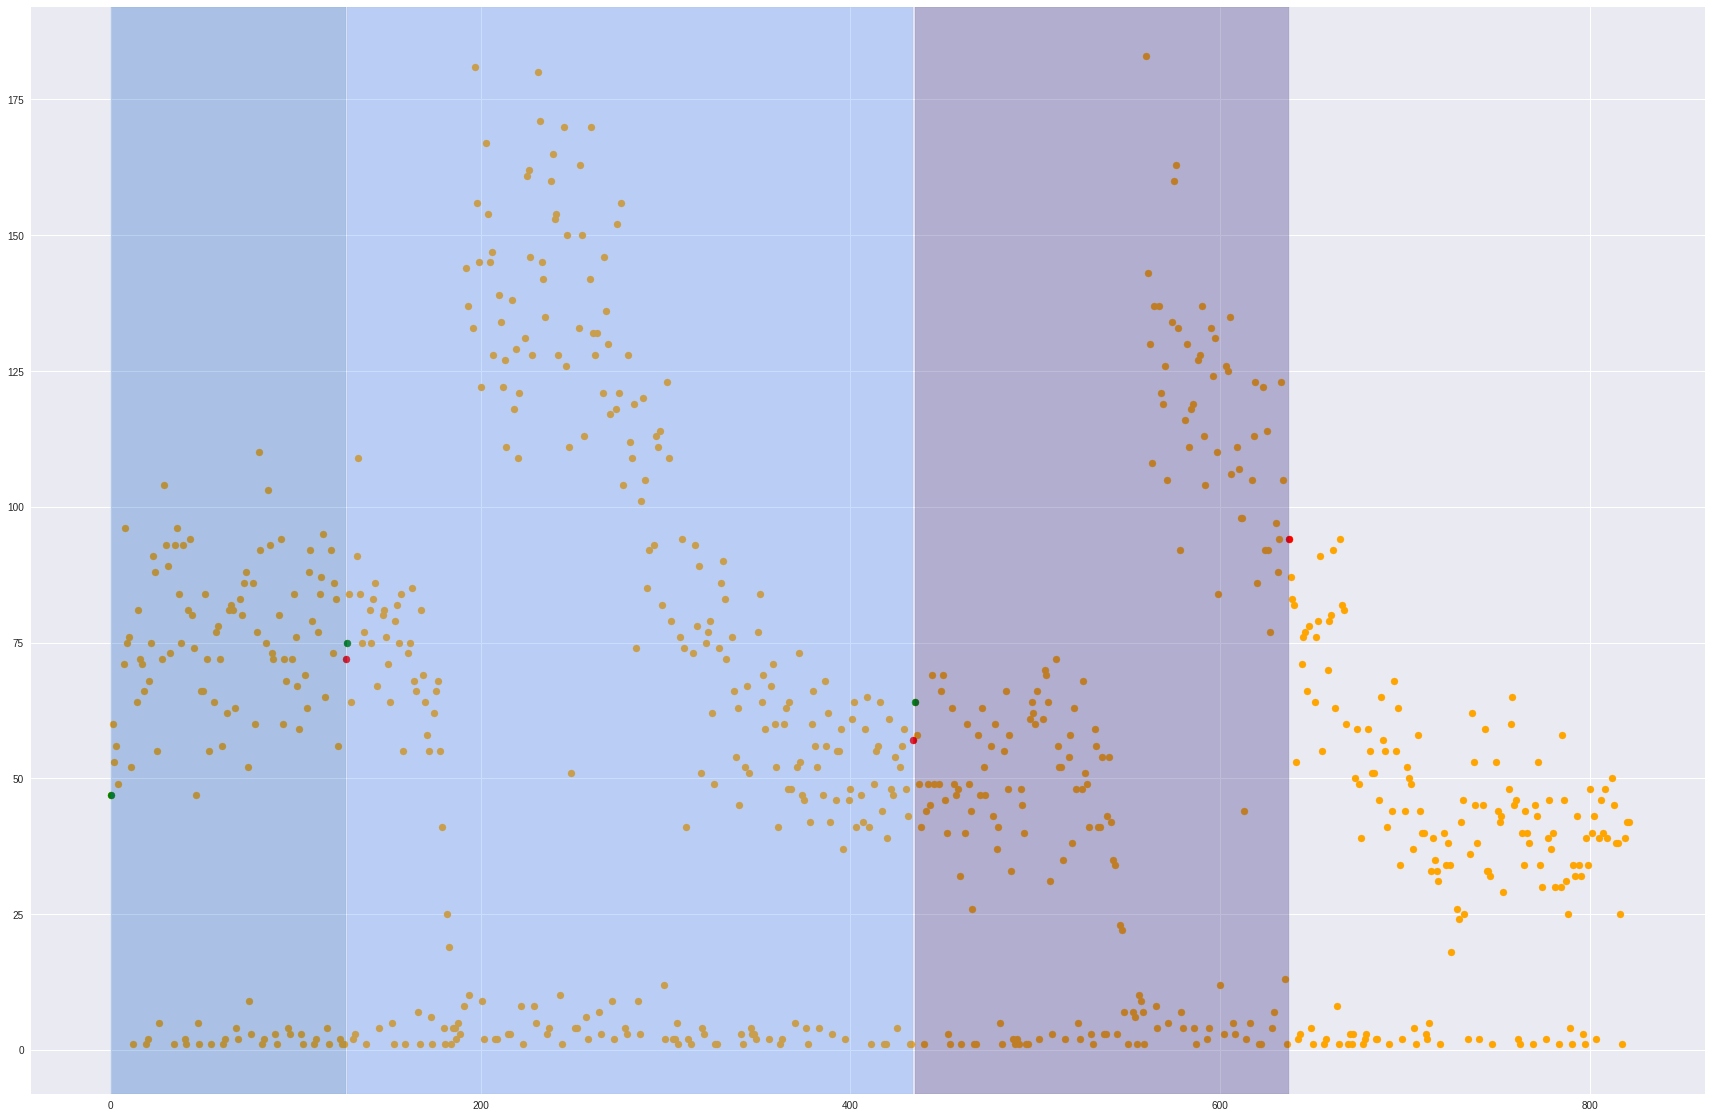

[(0, 127), (128, 434), (435, 637)]


In [191]:
#we can also filter values that bigger than mean but in not helps
#filtered_x = [x[0]] + [x[i] if y[i] > np.mean(y[0:i-1]) else None for i in range(1, len(y))]
#filtered_y = [y[0]] + [y[i] if y[i] > np.mean(y[0:i-1]) else None for i in range(1, len(y))]
#filtered_x = [x for x in filtered_x if x != None]
#filtered_y = [y for y in filtered_y if y != None]

filtered_x = x
filtered_y = y

markers_begin_x = []
markers_begin_y = []
markers_end_x = []
markers_end_y = []

curr = filtered_y[0]
start_y = filtered_y[0]
start_x = filtered_x[0]
saved_start_x = filtered_x[0]
saved_start_y = filtered_y[0]
inside = False
break_len = 8
gap_size = 14
saved = True
for i in range(1, len(filtered_x)):
    curr = filtered_y[i]
    #print(break_len, saved_start_x, saved_start_y, curr, inside)
    if (curr > start_y) & (not inside):
        if((filtered_x[i]-filtered_x[i-1]) <= gap_size):
            inside = True
        else:
            break_len = 1
            start_x = filtered_x[i]
            start_y = filtered_y[i]
            saved_start_x = start_x
            saved_start_y = start_y
    elif ((curr <= start_y) | (filtered_y[i-1]/curr>0.25) | (i==len(filtered_x)-1)) & inside:
        if(break_len > gap_size) | (i==len(filtered_x)-1):
            markers_end_x.append(filtered_x[i-1])
            markers_end_y.append(filtered_y[i-1])
            markers_begin_x.append(saved_start_x)
            markers_begin_y.append(saved_start_y)
            break_len = 1
            start_x = filtered_x[i]
            start_y = filtered_y[i]
            saved = False 
        if not saved:
            saved_start_x = start_x
            saved_start_y = start_y
            saved = True
        inside = False
    elif (curr > start_y) & inside:
        if((filtered_x[i]-filtered_x[i-1]) > gap_size):
            markers_end_x.append(filtered_x[i-1])
            markers_end_y.append(filtered_y[i-1])
            markers_begin_x.append(saved_start_x)
            markers_begin_y.append(saved_start_y)
            break_len = 1
            start_x = filtered_x[i]
            start_y = filtered_y[i]
            saved = False
    elif (curr <= start_y) & (not inside):
        start_y = curr
        start_x = filtered_x[i]
        break_len += filtered_x[i]-filtered_x[i-1]
    
X = np.array(filtered_x)
Y = np.array(filtered_y)
X = X.reshape(X.shape[0], 1)
Y = Y.reshape(Y.shape[0], 1)

X_b = np.array(markers_begin_x)
Y_b = np.array(markers_begin_y)
X_b = X_b.reshape(X_b.shape[0], 1)
Y_b = Y_b.reshape(Y_b.shape[0], 1)

X_e = np.array(markers_end_x)
Y_e = np.array(markers_end_y)
X_e = X_e.reshape(X_e.shape[0], 1)
Y_e = Y_e.reshape(Y_e.shape[0], 1)


fig, ax = plt.subplots(figsize=(30, 20))
plt.scatter(X, Y, color='orange')
plt.hold('on')

plt.scatter(X_e, Y_e, color='red')
plt.hold('on')
plt.scatter(X_b,Y_b, color='green')
plt.hold('on')

for i in range(len(markers_begin_x)):
    ax.axvspan(markers_begin_x[i], markers_end_x[i], alpha=0.3, color=np.random.rand(3,1))
plt.show()  

intervals = [(markers_begin_x[i], markers_end_x[i]) for i in range(len(markers_begin_x))]
print(intervals)

## Find trends: Experiment 2
    Using statsmodel we find it as combination of layers in additive model. Then for trend we find peaks and try to broad it to proper width  

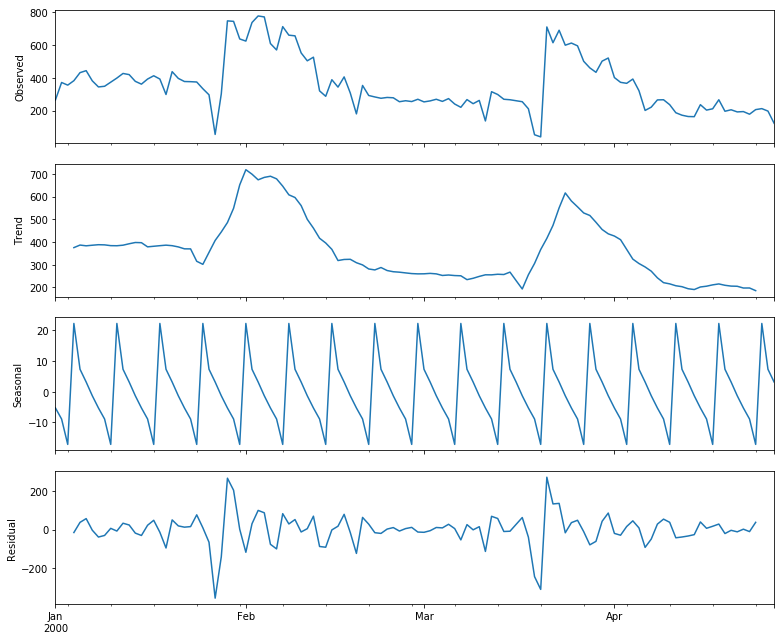

In [32]:
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

rcParams['figure.figsize'] = 11, 9

#weeks groupig
#weeks groupig
y_sum = []
x_sum = []
week_num = 0
for i in range(0, max(x), 7):
    l = [y[i] for i, xi in enumerate(x) if xi in list(range(week_num*7,week_num*7+6))]
    if l==[]:
        l = [0]
    y_sum.append(sum(l))
    x_sum.append(week_num)
    week_num += 1

dr = pd.date_range('2000-01-01', periods=len(x_sum))
decomposition = sm.tsa.seasonal_decompose(pd.DataFrame(y_sum, dr), model='additive')
fig = decomposition.plot()
plt.show()

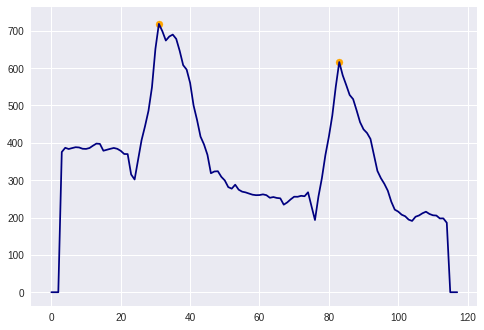

In [200]:
import peakutils
from scipy.signal import find_peaks_cwt

trend = decomposition.trend.reset_index().fillna(0)[0]

indexes = peakutils.indexes(trend, min_dist=7, thres=0.6)
plt.plot(trend, color='navy')
plt.hold('on')
d = [trend[i] for i in indexes]

plt.scatter(indexes, d, color='orange')
plt.show()

In [192]:
trends_list = []
tr = 4
for ind in indexes:
    begin = ind-1 if ind!=0 else ind
    end = ind+1 if ind!=(len(trend)-1) else ind
    done = False 
    no_impr_b = False
    no_impr_e = False
    while not done:
        if begin==end:
            trends_list.append((begin, end))
            done = True
        if (begin>1) & (trend[begin-1]<trend[end]):
            begin -= 1
        #elif (begin>tr):
        #    if (trend[begin-tr]<trend[begin]):
        #        begin -= tr
        else:
            no_impr_b = True
        if (end-1<len(trend)) & (trend[end-1]<trend[end]):
            end += 1
        #elif (end-tr<len(trend)) & (trend[end-tr]<trend[end]):
        #    end += tr
        else:
            no_impr_e = True
        if no_impr_b & no_impr_e:
            trends_list.append((begin, end))
            done = True
            no_impr_b = False
            no_impr_e = False
print(trends_list)

[(1, 32), (40, 84)]


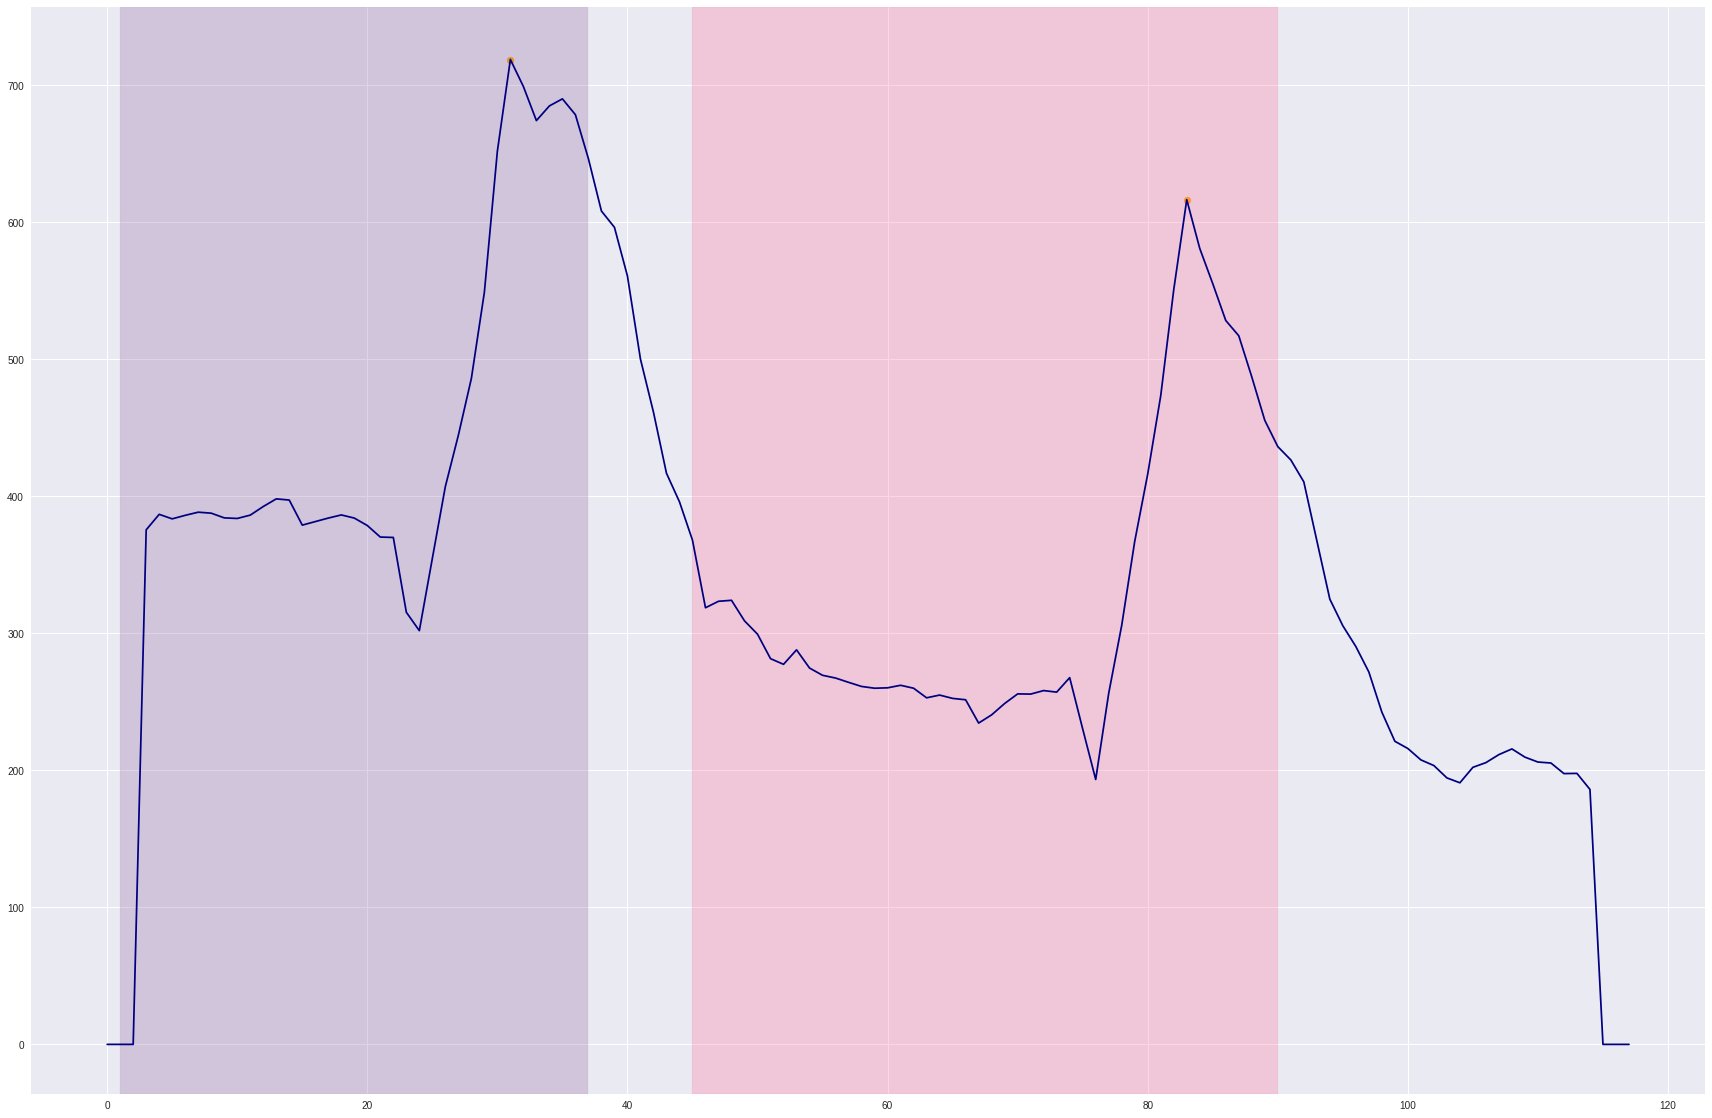

In [199]:
fig, ax = plt.subplots(figsize=(30, 20))

plt.plot(trend, color='navy')
plt.hold('on')
d = [trend[i] for i in indexes]

plt.scatter(indexes, d, color='orange')
plt.hold('on')

for i in range(len(trends_list)):
    ax.axvspan(x[trends_list[i][0]], x[trends_list[i][1]], alpha=0.3, color=np.random.rand(3,1))
plt.show() 


## Prediction: Experiment 1
    choose some features and fit them to SVR 

In [36]:
#weeks groupig
y_sum = []
y_mean = []
y_min = []
y_max = []
x_sum = []
week_num = 0
for i in range(0, max(x), 7):
    l = [y[i] for i, xi in enumerate(x) if xi in list(range(week_num*7,week_num*7+6))]
    if l==[]:
        l = [0]
    y_sum.append(sum(l))
    y_mean.append(np.mean(l))
    y_min.append(min(l))
    y_max.append(max(l))
    x_sum.append(week_num)
    week_num += 1

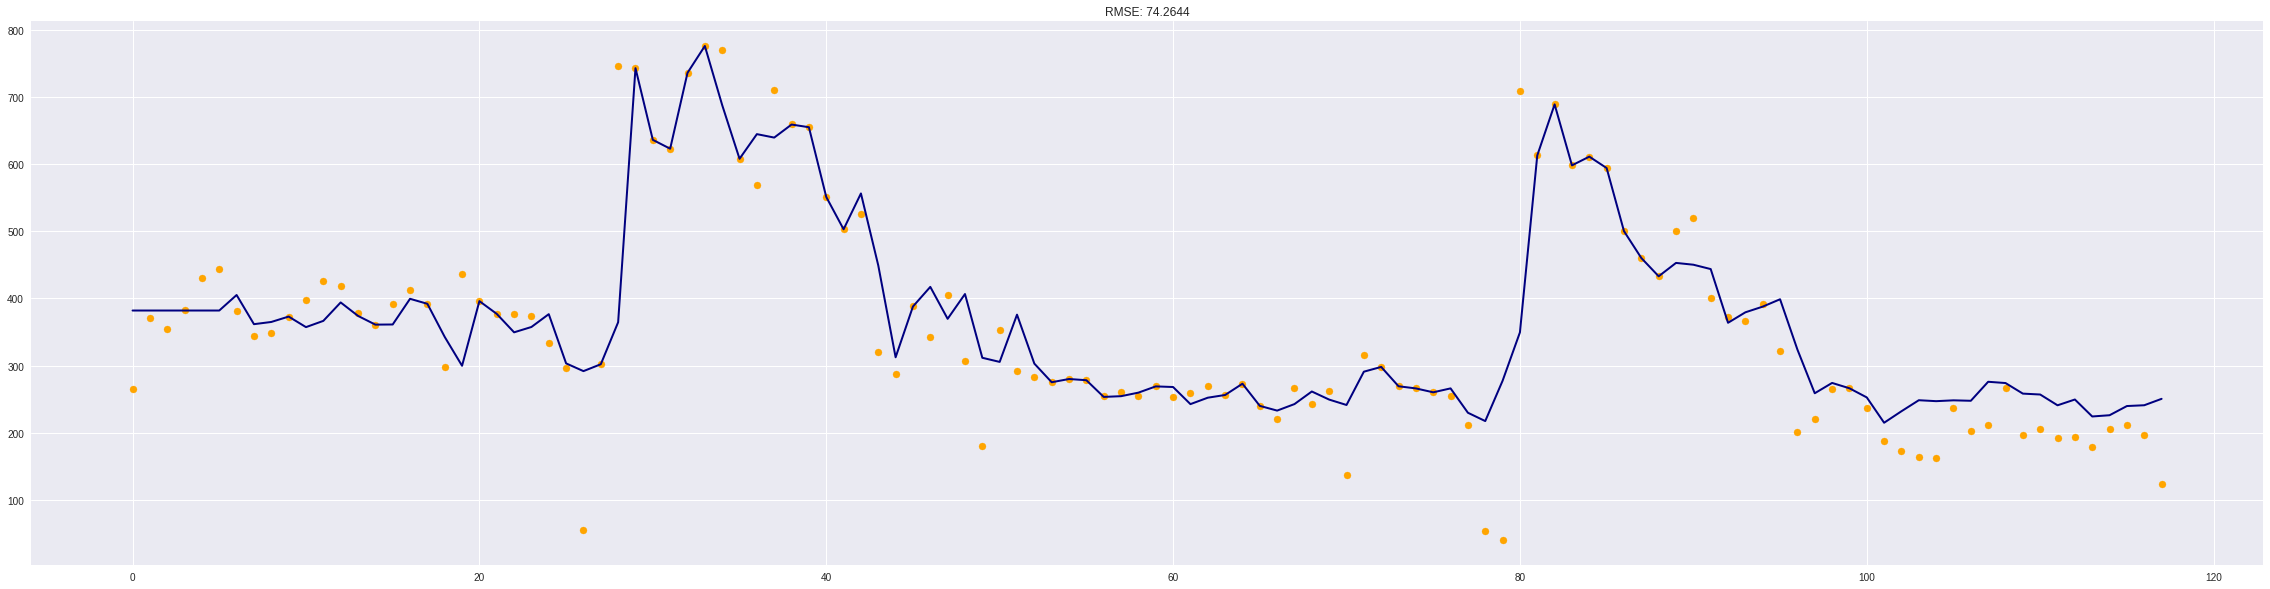

RMSE: 57.0497 for last 20


In [104]:
from sklearn.svm import SVR

l = len(x_sum)

plt.figure(figsize=(40, 10))
plt.scatter(x_sum, y_sum, color='orange')
plt.hold('on')

month = [i%12 for i in range(l)]
week_num = [i%4 for i in range(l)]
week_sum = [y_sum[i] for i in range(l)]
week_mean= [y_mean[i] for i in range(l)]
week_min = [y_min[i] for i in range(l)]
week_max = [y_max[i] for i in range(l)]

filters = [month, week_num, week_mean]

m_prev_week = [[0 for _ in range(6*len(filters))] for _ in range(0, 6)] + \
                                                      [[filt[i-1] for filt in filters] +
                                                      [filt[i-2] for filt in filters] +
                                                      [filt[i-3] for filt in filters] +
                                                      [filt[i-4] for filt in filters] +
                                                      [filt[i-5] for filt in filters] +
                                                      [filt[i-6] for filt in filters] for i in range(6, l)]

features = [[filt[i] for filt in filters] for i in range(l)]
clf = SVR(kernel='rbf', C=1000, gamma=0.0001)
X = np.array(m_prev_week)
Y = np.array(y_sum)
X = X.reshape(X.shape[0], len(filters)*6)
Y = Y.reshape(Y.shape[0], 1)
y_pred = clf.fit(X[:100], Y[:100]).predict(X) 

plt.plot(x_sum, y_pred, color='navy', lw=2)

plt.title('RMSE: %.4f'% np.sqrt(sum((y_sum-y_pred)**2)/len(Y)))
plt.show()

print('RMSE: %.4f for last 20'% np.sqrt(sum((y_sum[100:]-y_pred[100:])**2)/len(y_sum[100:])))

In [100]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVR

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.5, random_state=0)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 1e-5], 'C': [1, 10, 100, 1000, 10000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

clf = GridSearchCV(SVR(C=1), tuned_parameters, cv=5)
clf.fit(X_train, y_train)

print("Best parameters:")
print(clf.best_params_)
print("Grid scores:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters:
{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Grid scores:
-0.259 (+/-0.366) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
-0.228 (+/-0.361) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
-0.278 (+/-0.362) for {'C': 1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.063 (+/-0.364) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.194 (+/-0.383) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
-0.103 (+/-0.324) for {'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
0.526 (+/-0.347) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.606 (+/-0.407) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.341 (+/-0.485) for {'C': 100, 'gamma': 1e-05, 'kernel': 'rbf'}
0.517 (+/-0.366) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.640 (+/-0.378) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.555 (+/-0.563) for {'C': 1000, 'gamma': 1e-05, 'kernel': 'rbf'}
0.512 (+/-0.368) for {'C': 10000, 'gamma': 0.001, 'kernel': 'rbf'}
0.405 (+/-0.622) for {'C': 10000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.534 (

## Prediction: Experiment 2
    Try to combine AR and MA models using ARIMA from statsmodels.tsa.arima_model  

In [83]:
from statsmodels.tsa.stattools import adfuller
def stationarity(timeseries):
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)

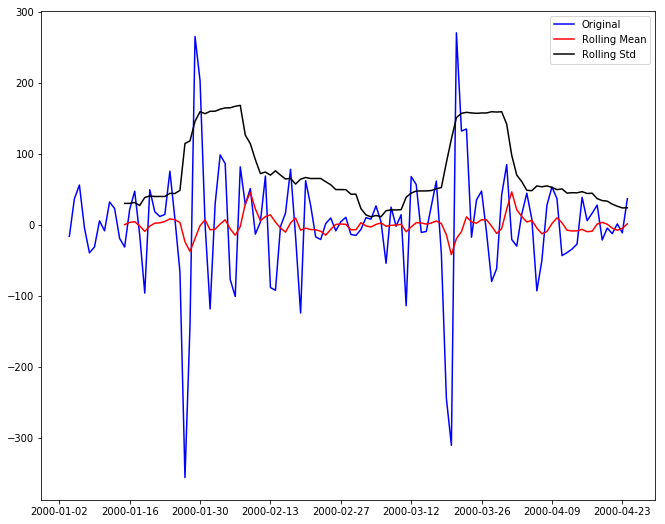

In [84]:
ts_log_decompose = decomposition.resid
ts_log_decompose.dropna(inplace=True)
stationarity(ts_log_decompose)

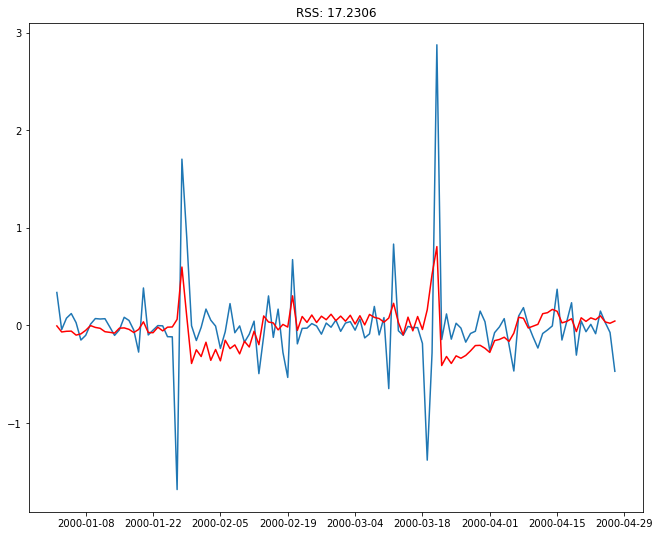

In [68]:
from statsmodels.tsa.arima_model import ARIMA

#peak random date
dr = pd.date_range('2000-01-01', periods=len(x_sum))
ts = pd.DataFrame(y_sum, dr)

#some problems with datetime, hot fixes
ts2 = ts.reset_index()
ts2['timestamp'] = pd.to_datetime(ts2['index'])
ts2 = ts2.rename(columns={0:'value'})
ts2 = ts2[['timestamp', 'value']]
ts2 = ts2.set_index(['timestamp'])

ts_log = np.log(ts2)
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)

model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues.reset_index()[0]-ts_log_diff.reset_index()['value'])**2))
plt.show()

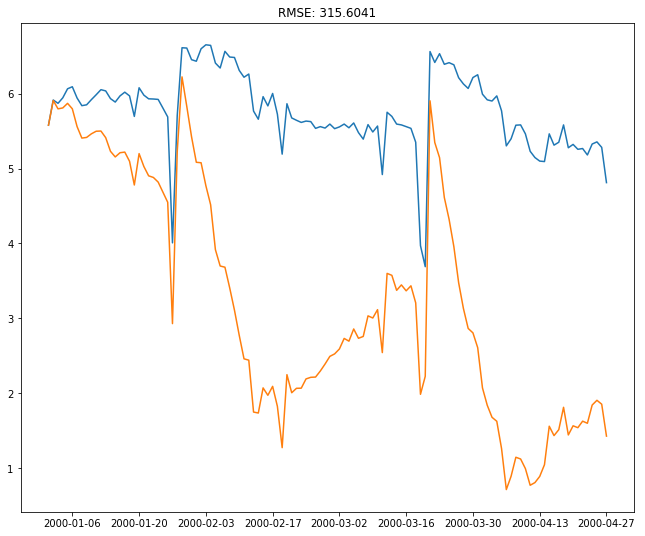

In [69]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.value, index=ts_log.index)

predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA.reset_index()[0].fillna(0)-ts.reset_index()[0])**2)/len(ts)))
plt.show()